In [1]:
import pickle
import os
import numpy as np
import healpy as hp
from astropy_healpix import HEALPix
import matplotlib.pyplot as plt
from astropy.io import fits
from healpy.rotator import Rotator
%matplotlib inline

In [3]:
cache_dir = "/Users/robertstein/Realtime_Stuff/alert_archive/EHE/"

candidate = "candidate_2010_EHE_alert_0.i3_event0000"

path = os.path.join(cache_dir, "{0}/step10_data.pickle".format(candidate))

In [4]:
with open(path, "r") as f:
    x = pickle.load(f)

In [60]:
output_dir = "/Users/robertstein/Realtime_Stuff/alert_archive/output_raw_fits/EHE/"
cache_dir = "/Users/robertstein/Realtime_Stuff/alert_archive/EHE/"



def parse_ehe(candidate):
    
    path = os.path.join(cache_dir, "{0}/step10_data.pickle".format(candidate))
    
#     with open(path, "r") as f:
#         x = pickle.load(f)
    
    data = np.array([(y["logl"]) for y in x[0]["SpiceMie"]], dtype=np.float)
    hdu = fits.PrimaryHDU(data=data)
    best_key = list(data).index(min(data))
    best_res = x[0]["SpiceMie"][best_key]
    hdr = hdu.header
    res = x[0]["SpiceMie"][-1]
    hdr.set('NSIDE', x[1]["SpiceMie"])
    hdr.set('Coord', "ICECUBE_LOCAL")
    hdr.set('time_mjd', res["time_mjd"])
    hdr.set('time_utc', res["time_string"])
    hdr.set("run_id", res["run_id"])
    hdr.set("DATA", "LOGL")
    hdr.set("minpixel", best_key)
    hdr.set("E_dep", best_res["depositedEnergy"])
    hdr.set("ICEMODEL", "SpiceMie")
    hdr.set("Stream", "EHE")
    hdr.set("GCN_SENT", False)
    output_file = os.path.join(output_dir, "{0}.fits".format(candidate))
    print("Writing to", output_file)
    hdu.writeto(output_file, overwrite=True)
    
parse_ehe("candidate_2010_EHE_alert_0.i3_event0000")

('Writing to', '/Users/robertstein/Realtime_Stuff/alert_archive/output_raw_fits/EHE/candidate_2010_EHE_alert_0.i3_event0000.fits')


In [74]:
with fits.open("/Users/robertstein/Realtime_Stuff/alert_archive/output_raw_fits/EHE/candidate_2010_EHE_alert_0.i3_event0000.fits") as hdul:
    data = hdul[0].data
    header = hdul[0].header

In [75]:
def switch_ra_azimuth(phi_in, mjd):
    """Givin MJD, transform azimuth->RA **or** RA->azimuth."""
    sidereal_day = 0.997269566 # sidereal day = length * solar day
    sidereal_offset = 2.54199002505 # RA = offset + 2pi * (MJD/sidereal_length)%1  - azimuth
    return (sidereal_offset + 2*np.pi*((mjd/sidereal_day)%1) - phi_in) % (2*np.pi)

In [78]:
print(switch_ra_azimuth(0.0, header["time_mjd"]))

1.76925353654


In [119]:
def rotate_to_equatorial(data):
    rot = Rotator(rot=[180. + np.degrees(switch_ra_azimuth(0.0, header["time_mjd"])), 180.0])
    return rot.rotate_map_pixel(data)
# rot = Rotator(rot=[180.0, 0.0])

In [121]:
rdata = rotate_to_equatorial(data)

In [122]:
max_index = list(rdata).index(min(rdata))
dec, ra = hp.pixelfunc.pix2ang(512, max_index)
ra = np.degrees(ra)
dec = np.degrees(np.pi/2. - dec)
print(ra, dec)

(331.083984375, 11.110881800003272)


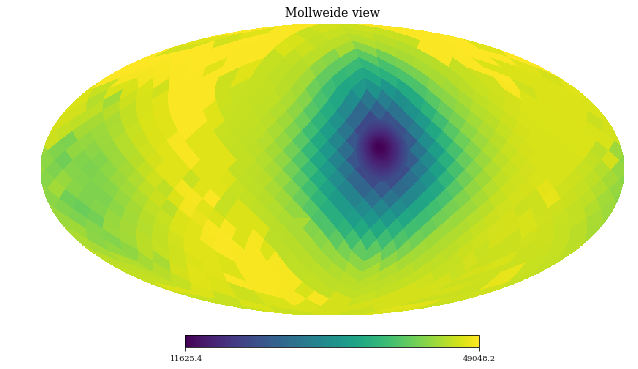

In [123]:
hp.mollview(rdata)

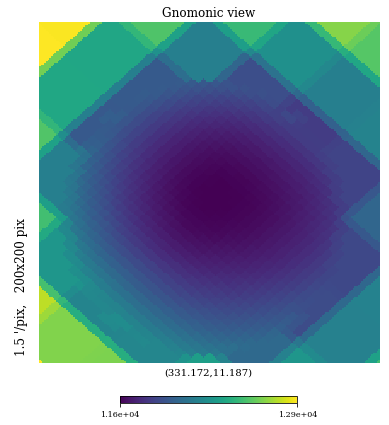

In [118]:
hp.gnomview(rdata, rot=[331.171875, 11.186920691664897])

In [5]:
print(x[0]["SpiceMie"][-1])

{'time_daq_nanosec': 862831327.9000001, 'rlogl': 20.62160330374215, 'zenith': 3.039486231207189, 'run_id': 116701, 'time_daq_year': 2010, 'azimuth': 5.497787143782138, 'nside': 8, 'ndof': 2237, 'seedZenith': 3.039486231207189, 'time_string': '2010-10-09 09:08:01.862,831,327,9 UTC', 'npixel': 768, 'seedAzimuth': 5.497787143782138, 'time_mjd': 55478.380577116106, 'logl': 46130.526590471185, 'pixel': 3145727, 'depositedEnergy': 70636.03937284299, 'name': 'unknown'}


In [6]:
output_dir = "/Users/robertstein/Realtime_Stuff/alert_archive/output_raw_fits/EHE/"

output_file = os.path.join(output_dir, "{0}.fits".format(candidate))
print(output_file)

/Users/robertstein/Realtime_Stuff/alert_archive/output_raw_fits/EHE/candidate_2010_EHE_alert_0.fits


In [46]:
# fitsio.write(output_file, np.array([y["logl"] for y in x[0]["SpiceMie"]], dtype=np.dtype([("logl", np.float)])))

NameError: name 'fitsio' is not defined

In [25]:
data = np.array([(y["logl"]) for y in x[0]["SpiceMie"]], dtype=np.float)

In [46]:
best_key = list(data).index(min(data))
best_res = x[0]["SpiceMie"][best_key]
print(best_res)

{'time_daq_nanosec': 862831327.9000001, 'rlogl': 5.1961439040131285, 'zenith': 1.7660449260239304, 'run_id': 116701, 'time_daq_year': 2010, 'azimuth': 4.776816173475886, 'nside': 512, 'ndof': 2237, 'seedZenith': 1.7660449260239304, 'time_string': '2010-10-09 09:08:01.862,831,327,9 UTC', 'npixel': 3145728, 'seedAzimuth': 4.776816173475886, 'time_mjd': 55478.380577116106, 'logl': 11623.773913277368, 'pixel': 1878549, 'depositedEnergy': 95031.52091004378, 'name': 'unknown'}


In [54]:
hdu = fits.PrimaryHDU(data=data)

In [55]:
hdr = hdu.header
res = x[0]["SpiceMie"][-1]
hdr.set('NSIDE', x[1]["SpiceMie"])
hdr.set('Coord', "ICECUBE_LOCAL")
hdr.set('time_mjd', res["time_mjd"])
hdr.set('time_utc', res["time_string"])
hdr.set("run_id", res["run_id"])
hdr.set("DATA", "LOGL")
hdr.set("minpixel", best_key)
hdr.set("E_dep", best_res["depositedEnergy"])
hdr.set("ICEMODEL", "SpiceMie")

In [56]:
print(hdu.header)


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    1 / number of array dimensions                     NAXIS1  =              3145728                                                  EXTEND  =                    T                                                  NSIDE   =                  512                                                  COORD   = 'ICECUBE_LOCAL'                                                       TIME_MJD=    55478.38057711611                                                  TIME_UTC= '2010-10-09 09:08:01.862,831,327,9 UTC'                               RUN_ID  =               116701                                                  DATA    = 'LOGL    '                                                            MIN_PIX =              1878549                                                  E_DEP   =    95031.52091004378          

In [43]:
hdu.writeto(output_file)

In [4]:
print(x[1]["SpiceMie"])

512


In [5]:
print(x[2]["SpiceMie"])

3145728


In [6]:
print(x[3]["SpiceMie"])

None


In [7]:
print(len(x[4]["SpiceMie"]))

147


In [8]:
print(x[5]["SpiceMie"])

9933.17779963


In [9]:
print(x[6]["SpiceMie"])

None


In [10]:
print(x[7]["SpiceMie"])

None


In [11]:
print(x[8]["SpiceMie"])

[9763.331523186554, 12720.894589795791]


In [12]:
print(len(x[9]["nsides"]))

3


In [45]:
probs = np.array([y["logl"] for y in x[0]["SpiceMie"]], dtype=np.dtype([("logl", np.float)]))
print(probs["logl"][:5])

[46757.70750444 46105.12850412 46701.09230764 46041.79476382
 46757.70750444]


In [13]:
def switch_ra_azimuth(phi_in, mjd):
    """Givin MJD, transform azimuth->RA **or** RA->azimuth."""
    sidereal_day = 0.997269566 # sidereal day = length * solar day
    sidereal_offset = 2.54199002505 # RA = offset + 2pi * (MJD/sidereal_length)%1  - azimuth
    return (sidereal_offset + 2*np.pi*((mjd/sidereal_day)%1) - phi_in) % (2*np.pi)

In [14]:
def unpack_map():
    probs_8_dict = dict()
    probs_64_dict = dict()
    probs_512_dict = dict()
    for y in x[0]["SpiceMie"]:
        dec = y["zenith"] - np.pi/2.
        ra = switch_ra_azimuth(y["azimuth"], y["time_mjd"])
        if y["nside"] == 8:
            pix = hp.pixelfunc.ang2pix(8, np.degrees(ra), np.degrees(dec), lonlat=True)
            probs_8_dict[pix] = y["logl"]
        elif y["nside"] == 64:
            pix = hp.pixelfunc.ang2pix(64, np.degrees(ra), np.degrees(dec), lonlat=True)
            probs_64_dict[pix] = y["logl"]
        elif y["nside"] == 512:
            pix = hp.pixelfunc.ang2pix(512, np.degrees(ra), np.degrees(dec), lonlat=True)
            probs_512_dict[pix] = y["logl"]

    for i in range(hp.pixelfunc.nside2npix(8)):
        if i not in probs_8_dict.keys():
            probs_8_dict[i] = np.nan
            
#     for i in range(hp.pixelfunc.nside2npix(64)):
#         if i not in probs_64_dict.keys():
#             probs_64_dict[i] = np.nan
            
#     for i in range(hp.pixelfunc.nside2npix(512)):
#         if i not in probs_512_dict.keys():
#             probs_512_dict[i] = np.nan

    probs_8 = np.array([y for _, y in sorted(probs_8_dict.items())])
    up_prob_8 = hp.pixelfunc.ud_grade(probs_8, nside_out=64)

    for i, p in probs_64_dict.items():
        up_prob_8[i] = p

    up_prob_64 = hp.pixelfunc.ud_grade(up_prob_8, nside_out=512)

    for i, p in probs_512_dict.items():
        up_prob_64[i] = p
#     probs_64 = np.array([y for _, y in sorted(probs_64_dict.items())])
#     probs_512 = np.array([y for _, y in sorted(probs_512_dict.items())])
    return up_prob_64

prob_map = unpack_map()

768


/usr/local/anaconda3/envs/millipede_parser/lib/python2.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/usr/local/anaconda3/envs/millipede_parser/lib/python2.7/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/usr/local/anaconda3/envs/millipede_parser/lib/python2.7/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


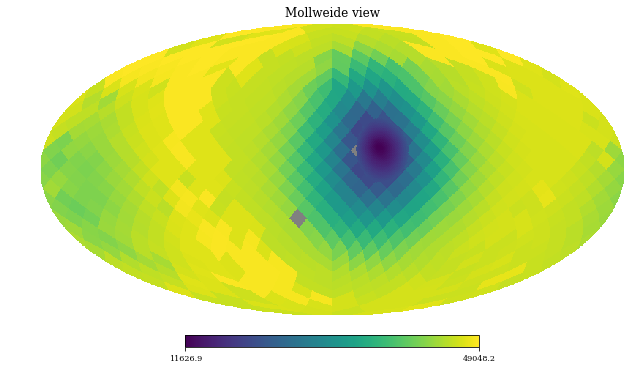

In [15]:
print(hp.pixelfunc.nside2npix(8))

# print(len(up_prob_8))
hp.mollview(prob_map)

In [16]:
print(x[10])

55478.3805771


In [17]:
print(x[11])

116701


In [18]:
hp.pixelfunc.nside2npix(512)

3145728

In [19]:
from scipy.stats import chi2, norm

In [20]:
def convert_ts(ts):
    return ts**0.5

In [21]:
print(chi2.ppf(0.0, 1))
print(norm.ppf(norm.cdf(convert_ts(25))))
print()

0.0
4.999999999970176
()


In [22]:
wilks = [1.39, 4.61, 11.83, 28.74]

for i in wilks:
    print(i, norm.ppf(0.5 + 0.5*chi2.cdf(i, 2)))
    
def convert_prob_ts(p):
    return chi2.ppf(p, 2)
    
def convert_sigma_ts(sig):
    return chi2.ppf(2*norm.cdf(sig) - 1.0, 2)
    
convert_prob_ts(0.5)
convert_prob_ts(0.9)

convert_sigma_ts(3.0)
convert_sigma_ts(5.0)


(1.39, 0.6759467600642973)
(4.61, 1.6460240839208509)
(11.83, 3.0001282177156106)
(28.74, 4.999643059160108)


28.743702426548186

In [23]:
print(norm.cdf(5.0))

0.9999997133484281


In [24]:
# probs = [y["logl"] for y in x[0]["SpiceMie"]]
probs = np.copy(prob_map)

In [25]:
threshold_50 = 22.2
threshold_90 = 64.2

contours = [
    (0.0, threshold_50, 0.0, 0.5),
    (threshold_50, threshold_90, 0.5, 0.9),
    (threshold_90, 100., 0.9, 0.99)
]

In [26]:
def apply_mask_rescale(probs, lower_ts, upper_ts, lower_prob, upper_prob):
    mask = np.logical_and(probs > lower_ts,
                          probs < upper_ts
                         )
    probs[mask] -= lower_ts
    expected_lower = convert_prob_ts(lower_prob)
    expected_upper = convert_prob_ts(upper_prob)
    probs[mask] *= (expected_upper - expected_lower)/(upper_ts - lower_ts)
    probs[mask] += expected_lower
    return probs

In [27]:
def convert_probs(probs):
    probs = np.array(probs)- min(probs)
    probs[np.isnan(probs)] = max(probs)

    for (lower_ts, upper_ts, lower_prob, upper_prob) in contours:
        probs = apply_mask_rescale(probs, lower_ts, upper_ts, lower_prob, upper_prob)
    
    probs = np.exp(-probs)
    probs /= np.sum(probs)
                
    print(np.sum(probs))
    return probs

In [28]:
probs = convert_probs(probs)

0.9999999999999999


In [29]:
print(len(probs))

3145728


(331.171875, 11.186920691664897)


[-743.34145963 -743.34145963 -743.34145963 ... -743.34145963 -743.34145963
 -743.34145963]


/usr/local/anaconda3/envs/millipede_parser/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


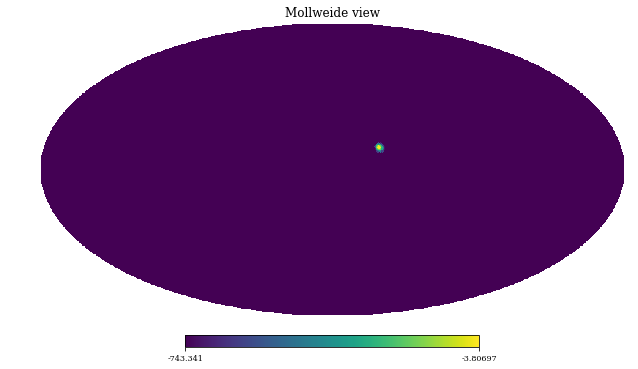

In [31]:
log_probs = np.log(probs)
log_probs[log_probs == -float("inf")] = min(log_probs[log_probs > -float("inf")])
print(log_probs)
hp.mollview(log_probs)

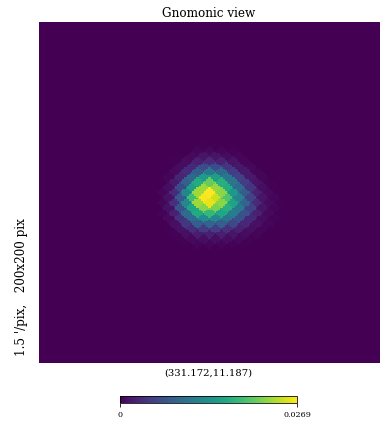

In [32]:
hp.gnomview(probs, rot=[331.171875, 11.186920691664897])

In [33]:
print(np.sum(probs))

0.9999999999999999


In [34]:
# ra_decs = np.array([[hp.pixelfunc.pix2ang(512, i, lonlat=True)] for i in range(hp.pixelfunc.nside2npix(512))]).T

In [1036]:
# delta = 1.

# print(np.deg2rad(ra))
# print(max(ra_decs[0][0]), min(ra_decs[0][0]))
# print(np.sum(np.logical_and(
#     ra_decs[0][0] > ra - delta,
#     ra_decs[0][0] < ra + delta
# )))

# print(np.sum(
#     np.logical_and(
#         ra_decs[1][0] > dec - delta,
#         ra_decs[1][0] < dec + delta
#     )
# ))

# print(max(ra_decs[1][0]), min(ra_decs[1][0]))

# mask = np.logical_and(
#     np.logical_and(
#         ra_decs[0][0] > ra - delta,
#         ra_decs[0][0] < ra + delta
#     ),
#     np.logical_and(
#         ra_decs[1][0] > dec - delta,
#         ra_decs[1][0] < dec + delta
#     )
# )

# print(len(ra_decs.T[0]), np.sum(mask))
# plt.scatter(ra_decs[0][0][mask], ra_decs[1][0][mask], c=probs[mask])

In [35]:
def find_pixel_threshold(probs, threshold):
    ranked_pixels = np.sort(probs)[::-1]
    int_sum = 0.0
    pixel_threshold = 0.0

    for i, prob in enumerate(ranked_pixels):
        int_sum += prob
        if int_sum > threshold:
            pixel_threshold = prob
            break
    return pixel_threshold

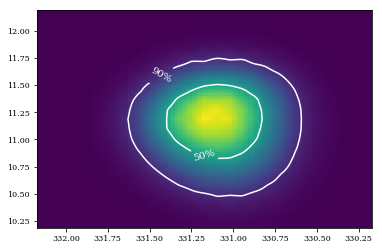

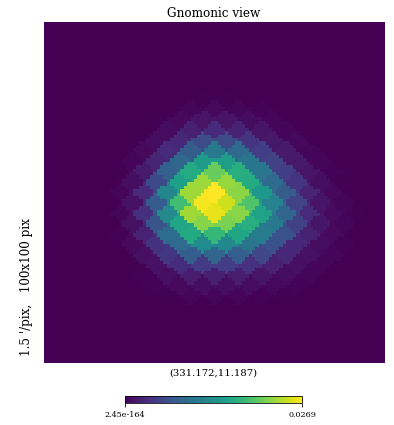

In [37]:
delta = 1.
ras = np.linspace(ra - delta, ra+delta, 101)
decs = np.linspace(dec - delta, dec + delta, 101)

ps = []

for r in ras:
    row = []
    for d in decs:
        row.append(hp.pixelfunc.get_interp_val(probs, r, d, lonlat=True))
    ps.append(row)
    
ps = np.array(ps)

threshold_50 = find_pixel_threshold(probs, 0.5)
threshold_90 = find_pixel_threshold(probs, 0.9)
threshold_99 = find_pixel_threshold(probs, 0.99)

levels = [threshold_90, threshold_50]

ax = plt.subplot(111)
image = ax.pcolormesh(ras, decs, ps, vmin=0, vmax=max(probs))
fig = hp.gnomview(probs, rot=[331.171875, 11.186920691664897], xsize=100)
plt.scatter(ra, dec, marker="*", color="black")
CS = ax.contour(ras, decs, ps, colors="white", levels=levels)
ax.clabel(CS, inline=1, fontsize=10, fmt={threshold_99: "99%", threshold_90: "90%", threshold_50: "50%"})
ax.invert_xaxis()
plt.show()

# Extrapolate contour base on 50-90 gradient

In [358]:
# Use Green's theorem to compute the area
# enclosed by the given contour.
def area(vs):
    a = 0
    x0,y0 = vs[0]
    for [x1,y1] in vs[1:]:
        dx = x1-x0
        dy = y1-y0
        a += 0.5*(y0*dx - x0*dy)
        x0 = x1
        y0 = y1
    return a

In [39]:
for i in range(len(levels)):
    vs = CS.collections[i].get_paths()[0].vertices
    # Compute area enclosed by vertices.
    a = area(vs) # will be in square-radians
#     a = a*(180.*180.)/(np.pi*np.pi) # convert to square-degrees
    print(i, a)

(0, 21.885598573473946)
(1, 10.008167634568926)


In [124]:
path = "/Users/robertstein/Realtime_Stuff/alert_archive/output_raw_fits/fits_v2_with_contextual_info/candidate_2010_EHE_alert_0.i3_event0000.fits"

In [125]:
with fits.open(path) as hdul:
    data = hdul[0].data
    header = hdul[0].header

In [136]:
from scipy.stats import chi2, norm
wilks = [1.39, 4.61, 11.83, 28.74]

for i in wilks:
    print(i, norm.ppf(0.5 + 0.5*chi2.cdf(i, 2)))
    
def convert_prob_ts(p):
    return chi2.ppf(p, 2)
    
def convert_sigma_ts(sig):
    return chi2.ppf(2*norm.cdf(sig) - 1.0, 2)

(1.39, 0.6759467600642973)
(4.61, 1.6460240839208509)
(11.83, 3.0001282177156106)
(28.74, 4.999643059160108)


In [185]:
threshold_50 = 22.2
threshold_90 = 64.2

expected_lower = convert_prob_ts(0.5)
expected_upper = convert_prob_ts(0.9)
grad_50_90 = (expected_upper - expected_lower)/(threshold_90 - threshold_50)

def extrapolate_ts_from_90(p):
    return threshold_90 + (convert_prob_ts(p) - expected_upper)/grad_50_90

# print(convert_prob_ts(0.99), convert_prob_ts(0.90))
# print(extrapolate_ts_from_90(0.99))
# print((convert_prob_ts(0.99)-convert_prob_ts(0.90))/grad_50_90)

# print(grad_50_90)

contours = [
    (0.0, threshold_50, 0.0, 0.5),
    (threshold_50, threshold_90, 0.5, 0.9),
    (threshold_90, extrapolate_ts_from_90(0.99), 0.9, 0.99)
]

In [186]:
def apply_mask_rescale(probs, lower_ts, upper_ts, lower_prob, upper_prob):
    mask = np.logical_and(probs > lower_ts,
                          probs < upper_ts
                         )
    probs[mask] -= lower_ts
    expected_lower = convert_prob_ts(lower_prob)
    expected_upper = convert_prob_ts(upper_prob)
    probs[mask] *= (expected_upper - expected_lower)/(upper_ts - lower_ts)
    probs[mask] += expected_lower
    return probs

In [187]:
def convert_probs(data):
    probs = np.copy(data)
    probs = np.array(probs)- min(probs)
    probs[np.isnan(probs)] = max(probs)

    for (lower_ts, upper_ts, lower_prob, upper_prob) in contours:
        probs = apply_mask_rescale(probs, lower_ts, upper_ts, lower_prob, upper_prob)
    
    probs = np.exp(-probs)
    probs /= np.sum(probs)
                
    print(np.sum(probs))
    return probs

In [188]:
# probs = convert_probs(data)

1.0000000000000002


In [2]:
v3_dir = '/Users/robertstein/Realtime_Stuff/alert_archive/output_raw_fits/fits_v3_prob_map/'

In [15]:
from matplotlib import cm
import fitsio
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# fermi_catalogue = os.path.join(os.path.dirname(os.path.abspath(__file__)), "gll_psc_v19.fit")
fermi_catalogue = "/Users/robertstein/Code/millipede_parser/gll_psc_v19.fit"

def find_pixel_threshold(probs, threshold):
    ranked_pixels = np.sort(probs)[::-1]
    int_sum = 0.0
    pixel_threshold = 0.0

    for i, prob in enumerate(ranked_pixels):
        int_sum += prob
        if int_sum > threshold:
            pixel_threshold = prob
            break
    return pixel_threshold

def get_best_pixel(probs):
    max_index = list(probs).index(max(probs))
    dec, ra = hp.pixelfunc.pix2ang(512, max_index)
    ra = np.degrees(ra)
    dec = np.degrees(np.pi/2. - dec)
    return ra, dec

# Use Green's theorem to compute the area
# enclosed by the given contour.
def area(vs):
    a = 0
    x0,y0 = vs[0]
    for [x1,y1] in vs[1:]:
        dx = x1-x0
        dy = y1-y0
        a += 0.5*(y0*dx - x0*dy)
        x0 = x1
        y0 = y1
    return a


def plot_candidate(candidate, cache_dir=v3_dir):
    path = os.path.join(cache_dir, candidate)
    
    with fits.open(path) as hdul:
        probs = hdul[0].data
        header = hdul[0].header
        
    nside = hp.pixelfunc.npix2nside(len(probs))
    
    threshold_90 = find_pixel_threshold(probs, 0.9)
    mask = probs > (threshold_90/5.)
    
    pos = np.array([hp.pixelfunc.pix2ang(512, i, lonlat=True) for i in np.array(range(len(probs)))[mask]]).T
    
    min_ra = min(pos[0])
    max_ra = max(pos[0])
    min_dec = min(pos[1])
    max_dec = max(pos[1])
            
    ra, dec = get_best_pixel(probs)
    
    wrap_around = False
    
    if not np.logical_and(ra > min_ra, max_ra > ra):
        min_ra += 360
        wrap_around = True
        
    ra_delta = abs(max_ra - min_ra)
        
    ras = np.linspace(min([min_ra, max_ra]), min([min_ra, max_ra]) + ra_delta, 101)
    decs = np.linspace(min_dec, max_dec, 101)
    
    log_p = np.log(probs)

    ps = []

    for d in decs:
        row = []
        for r in ras:
            row.append(np.exp(hp.pixelfunc.get_interp_val(log_p, r, d, lonlat=True)))
#             row.append(hp.pixelfunc.get_interp_val(probs, r, d, lonlat=True))
        ps.append(row)

    ps = np.array(ps)

    threshold_50 = find_pixel_threshold(probs, 0.5)
    threshold_90 = find_pixel_threshold(probs, 0.9)
    threshold_99 = find_pixel_threshold(probs, 0.99)

    levels = [threshold_90, threshold_50]
    
    y_inches = 3.0
    x_inches = 6.
    
    fig = plt.figure(figsize=[x_inches, x_inches])
    
#     center = SkyCoord(mid_x, mid_y, unit=['deg','deg'])

    wcs = WCS(header)
    
    ax = plt.subplot(
            projection=wcs
    )

    image = ax.pcolormesh(ras, decs, ps, vmin=0, vmax=max(probs), cmap="inferno")
    plt.scatter(ra, dec, marker="*", color="black")
    CS = ax.contour(ras, decs, ps, colors="white", levels=levels)
    CS_99 = ax.contour(ras, decs, ps, colors="white", alpha=0., levels=[threshold_99, threshold_90, threshold_50])
    
    all_decs = []
    all_ras = []
    for segs in CS_99.allsegs:
        for k in segs:
            all_decs += list(k.T[1])
            all_ras += list(k.T[0])
    
    mid_y = np.mean([min(all_decs), max(all_decs)])
    mid_x = np.mean([min(all_ras), max(all_ras)])
    
    width = max([(max(all_decs) - min(all_decs)), (max(all_ras) - min(all_ras))])/2.
        
    lower_x = mid_x - width
    upper_x = mid_x + width
    lower_y = mid_y - width*abs(np.cos(np.radians(mid_y)))
    upper_y = mid_y + width*abs(np.cos(np.radians(mid_y)))
    
    ax.set_ylim(lower_y, upper_y)
    ax.set_xlim(lower_x, upper_x)
    
    contour_labels = ["90%", "50%"]
    
    npix = (4. * width**2)/hp.nside2pixarea(nside, degrees=True)
        
    for i in range(len(levels)):
        a = 0.
        for m in CS.collections[i].get_paths():
            a += abs(area(m.vertices))
        a *= abs(np.cos(np.radians(mid_y)))
        CS.collections[i].set_label('{0} - area: {1:.2f} sqdeg'.format(contour_labels[i], a))
        
    ax.clabel(CS, inline=1, fontsize=10, fmt={threshold_99: "99%", threshold_90: "90%", threshold_50: "50%"})
    ax.scatter(ra, dec, marker="*", color="black", s=100)
    
    with fits.open(fermi_catalogue) as hdul:
        fgl = hdul[1].data
        
    if wrap_around:
        fgl['RAJ2000'][fgl['RAJ2000'] < lower_x] += 360.
        
    mask = np.logical_and(
        np.logical_and(
            fgl['RAJ2000'] > lower_x,
            fgl['RAJ2000'] < upper_x
        ),
        np.logical_and(
            fgl['DEJ2000'] > lower_y,
            fgl['DEJ2000'] < upper_y
        )
    )
    
    if np.sum(mask) > 0:
        
        ax.scatter(
            fgl['RAJ2000'][mask], fgl['DEJ2000'][mask], s=50, marker='o', color='orange'
        )
    
        ax.scatter(
            fgl['RAJ2000'][mask], fgl['DEJ2000'][mask], s=10, marker='o', color='navy'
        )
        
        if np.sum(mask) < 30:
            for i in range(np.sum(mask)):
                ax.text(
                    fgl['RAJ2000'][mask][i] - 0.05 * width, fgl['DEJ2000'][mask][i], 
                    fgl['Source_Name'][mask][i], color='white', bbox=dict(facecolor='black', alpha=0.5),
                fontsize=10
                )
    
    ax.invert_xaxis()
    ax.grid(which="both", linestyle=":")
    ax.legend()
    ax.set_facecolor('black')
    ax.set_xlabel("Right Ascension (deg)")
    ax.set_ylabel("Declination (deg)")
    plt.show()
    fig = hp.gnomview(probs, rot=[mid_x, mid_y], xsize=npix)
    fig = hp.gnomview(np.log(probs), rot=[mid_x, mid_y], xsize=npix)

In [16]:
# plot_candidate("123326.i3.bz2_event0000.fits")
plot_candidate("candidate_2010_EHE_alert_0.i3_event0000.fits")

/usr/local/anaconda3/envs/millipede_parser/lib/python2.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


IndexError: list index out of range

<Figure size 432x432 with 0 Axes>

In [506]:
with fits.open(v3_path) as hdul:
    probs = hdul[0].data
    header = hdul[0].header

In [307]:
def find_pixel_threshold(probs, threshold):
    ranked_pixels = np.sort(probs)[::-1]
    int_sum = 0.0
    pixel_threshold = 0.0

    for i, prob in enumerate(ranked_pixels):
        int_sum += prob
        if int_sum > threshold:
            pixel_threshold = prob
            break
    return pixel_threshold

/usr/local/anaconda3/envs/millipede_parser/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


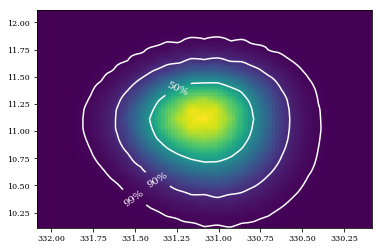

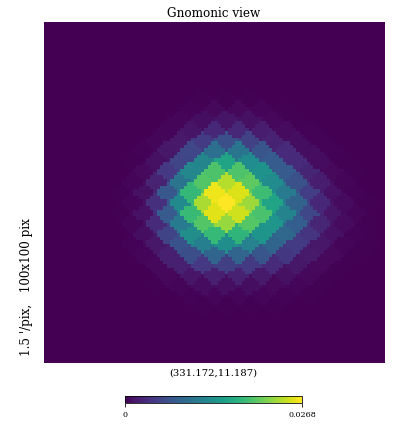

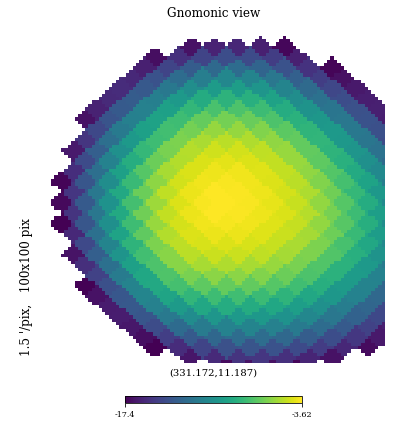

In [208]:
delta = 1.
ras = np.linspace(ra - delta, ra+delta, 101)
decs = np.linspace(dec - delta, dec + delta, 101)

ps = []

for r in ras:
    row = []
    for d in decs:
        row.append(hp.pixelfunc.get_interp_val(probs, r, d, lonlat=True))
    ps.append(row)
    
ps = np.array(ps)

threshold_50 = find_pixel_threshold(probs, 0.5)
threshold_90 = find_pixel_threshold(probs, 0.9)
threshold_99 = find_pixel_threshold(probs, 0.99)

levels = [threshold_99, threshold_90, threshold_50]

ax = plt.subplot(111)
image = ax.pcolormesh(ras, decs, ps, vmin=0, vmax=max(probs))
fig = hp.gnomview(probs, rot=[331.171875, 11.186920691664897], xsize=100)
fig = hp.gnomview(np.log(probs), rot=[331.171875, 11.186920691664897], xsize=100)
plt.scatter(ra, dec, marker="*", color="black")
CS = ax.contour(ras, decs, ps, colors="white", levels=levels)
ax.clabel(CS, inline=1, fontsize=10, fmt={threshold_99: "99%", threshold_90: "90%", threshold_50: "50%"})
ax.invert_xaxis()
plt.show()